In [1]:
# FEniCS for spatial FEM
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

## Create temporal basis in SymPy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import Mul, Id, symbols, init_printing, expand, compose, diff, lambdify, Piecewise
from IPython.display import Math, display
from fenics import UnitSquareMesh, Function, TrialFunction, TestFunction, TestFunctions, FunctionSpace, dx, inner, grad, FiniteElement, MixedElement, Constant, assemble, Expression, interpolate, solve, DirichletBC, plot, errornorm, set_log_active, derivative, parameters
from ufl import replace
import time
import pandas as pd

#set_log_active(False) # turn off FEniCS logging
parameters["reorder_dofs_serial"] = False

t = symbols("t")
init_printing()

# HELPER FUNCTIONS
# compute temporal basis functions from the roots
def compute_basis_functions(roots):
    basis = []
    for i in range(len(roots)):
        f = 1 + 0*Id(t)
        for j in range(len(roots)):
            if i != j:
                f = Mul(f,(t - roots[j]) / (roots[i] - roots[j]))
        #basis.append(f)
        basis.append(expand(f))
    return basis

# transform roots from [-1, 1] to [0, 1]
def transform_roots(roots):
    new_roots = []
    for root in roots:
        new_roots.append((root + 1) / 2)
    return new_roots

# dictionary of temporal bases depending on the polynomial degree
# FE basis on reference element (0,1)
φ = {}
roots = {}

roots[0] = [1.]
φ[0] = [1 + 0*Id(t)]
roots[1] = [0., 1.]
φ[1] = [1-t, t]
roots[2] = transform_roots([-1, 0, 1])
φ[2] = compute_basis_functions(roots[2])
#roots[3] = transform_roots([-1, -sqrt(Rational(1,5)), sqrt(Rational(1,5)), 1])
#φ[3] = compute_basis_functions(roots[3])

class TimeFE:
    def __init__(self, r=1, a=0., b=1., n_time=1, n_q_points=3):
        self.r = r # polynomial degree in time
        self.n_time = n_time # number of temporal elements
        self.n_dofs = (self.r+1) * self.n_time # total number of temporal dofs on slab
        self.dof_locations = []
        self.a = a # start time of slab
        self.b = b # end time of slab
        self.k = (self.b - self.a) / self.n_time
        self.epsilon = self.k * 1e-14

        self.generate_mesh()
        self.get_full_basis()
        self.lambdify_basis()
        self.compute_quadrature(n_q_points)

    def generate_mesh(self):
        # create an uniform temporal mesh with mesh size self.k
        self.mesh = [(self.a, self.a+self.k)]
        while len(self.mesh) < self.n_time:
            self.mesh.append((self.mesh[-1][1], self.mesh[-1][1]+self.k))

    # transform basis functions from [0,1] to [a,b]
    def transform_function(self, f, a, b):
        return compose(f, (t-a)/(b-a)) # = f((t-a)/(b-a))
    
    def transform_derivative(self, a, b):
        return 1 / (b-a)

    # get full FE basis and its derivative on temporal mesh
    def get_full_basis(self):
        self._basis = []
        self._basis_derivative = []
        self.local_dofs = {}
        i = 0
        for (a,b) in self.mesh:
            self.local_dofs[(a,b)] = []
            for f, t_q in zip(φ[self.r], roots[self.r]):
                self._basis.append(self.transform_function(f, a, b))
                self._basis_derivative.append(diff(self._basis[-1],t))
                #print(diff(self._basis[-1],t))
                #print(self.transform_function(diff(f,t), a, b) * self.transform_derivative(a, b))
                self.local_dofs[(a,b)].append(i)
                self.dof_locations.append(t_q*(b-a)+a)
                i += 1

    # convert SymPy functions to Python functions and ensure that they are 0 outside the element that they are defined on
    def lambdify_basis(self):
        self.phi = []
        self.dt_phi = []

        for (a,b) in self.mesh:
            for i in self.local_dofs[(a,b)]:
                self.phi.append(
                    lambdify(
                        t,
                        Piecewise(
                            (0, t < a),
                            (0, t > b),
                            (self._basis[i], True)
                        )
                    )
                )

                self.dt_phi.append(
                    lambdify(
                        t,
                        Piecewise(
                            (0, t < a),
                            (0, t > b),
                            (self._basis_derivative[i], True)
                        )
                    )
                )

    def compute_quadrature(self, n_q_points):
        # Gauss-Legendre quadrature points and weights on [-1,1]
        quad_points, quad_weights = np.polynomial.legendre.leggauss(n_q_points)

        # transform quadrature points and weights from [-1,1] to [a,b] for each temporal element [a,b]
        self.quadrature = {}
        for (a, b) in self.mesh:
            t_q = 0.5 * (b-a) * quad_points + 0.5 * (a+b)
            w_q = 0.5 * (b-a) * quad_weights
            self.quadrature[(a,b)] = [(t_q[i], w_q[i]) for i in range(t_q.shape[0])]
            
        # Gauss-Legendre quadrature points and weights on [-1,1]
        quad_points, quad_weights = np.polynomial.legendre.leggauss(n_q_points+2)

        # transform quadrature points and weights from [-1,1] to [a,b] for each temporal element [a,b]
        self.quadrature_fine = {}
        for (a, b) in self.mesh:
            t_q = 0.5 * (b-a) * quad_points + 0.5 * (a+b)
            w_q = 0.5 * (b-a) * quad_weights
            self.quadrature_fine[(a,b)] = [(t_q[i], w_q[i]) for i in range(t_q.shape[0])]

    def plot_basis(self, basis_type="function", title=None):
        assert basis_type in ["function", "derivative"], f"basis_type='{basis_type}' has not been implemented."

        _t = np.linspace(self.a, self.b, 100)
        for i in range(len(self.phi)):
            if basis_type == "function":
                plt.plot(_t, [self.phi[i](time_point) for time_point in _t], label=rf"$\varphi_{{{i}}}$")
            elif basis_type == "derivative":
                plt.plot(_t, [self.dt_phi[i](time_point) for time_point in _t], label=rf"$\partial_t \varphi_{{{i}}}$")

        plt.xlabel("t")
        plt.ylabel("f(t)")
        plt.legend()
        if title is not None:
            plt.title(title)
        plt.show()
        
    def get_solution_at_time(self, time_point, Vh):
        tmp = interpolate(Constant(0.), Vh)
        for i in range(self.n_dofs):
            tmp.vector()[:] += Time.phi[i](time_point) * U.sub(i, deepcopy=True).vector()[:]
        return tmp

## Assemble space-time integrals using numerical quadrature in time and FEniCS forms in space

CONFIG: s = 1, r = 1, slab_size = 0.015625, n_x = 12
Solving on slab_0 = Ω x (0.0, 0.01562) ...
eq.lhs =  { v_0[0] * f_14[0] * f_17 } * dx(<Mesh #0>[everywhere], {})
  +  { f_19 * v_0[0] * f_14[0] } * dx(<Mesh #0>[everywhere], {})
  +  { f_20 * (conj(((grad(v_0[0])) : (grad(f_14[0]))))) } * dx(<Mesh #0>[everywhere], {})
  +  { f_21 * v_0[0] * f_14[0] } * dx(<Mesh #0>[everywhere], {})
  +  { f_22 * (conj(((grad(v_0[0])) : (grad(f_14[0]))))) } * dx(<Mesh #0>[everywhere], {})
  +  { f_23 * v_0[0] * f_14[1] } * dx(<Mesh #0>[everywhere], {})
  +  { f_24 * (conj(((grad(v_0[0])) : (grad(f_14[1]))))) } * dx(<Mesh #0>[everywhere], {})
  +  { f_25 * v_0[0] * f_14[1] } * dx(<Mesh #0>[everywhere], {})
  +  { f_26 * (conj(((grad(v_0[0])) : (grad(f_14[1]))))) } * dx(<Mesh #0>[everywhere], {})
  +  { f_27 * f_14[0] * v_0[1] } * dx(<Mesh #0>[everywhere], {})
  +  { f_28 * ((grad(f_14[0])) : (grad(v_0[1]))) } * dx(<Mesh #0>[everywhere], {})
  +  { f_29 * f_14[0] * v_0[1] } * dx(<Mesh #0>[everywhere], {

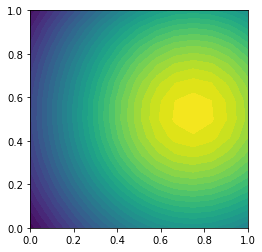

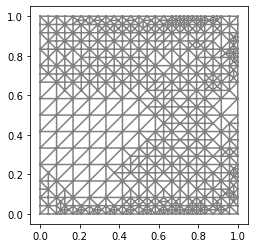

Done.

Solving on slab_1 = Ω x (0.01562, 0.03125) ...
eq.lhs =  { v_0[0] * f_852[0] * f_855 } * dx(<Mesh #838>[everywhere], {})
  +  { f_857 * v_0[0] * f_852[0] } * dx(<Mesh #838>[everywhere], {})
  +  { f_858 * (conj(((grad(v_0[0])) : (grad(f_852[0]))))) } * dx(<Mesh #838>[everywhere], {})
  +  { f_859 * v_0[0] * f_852[0] } * dx(<Mesh #838>[everywhere], {})
  +  { f_860 * (conj(((grad(v_0[0])) : (grad(f_852[0]))))) } * dx(<Mesh #838>[everywhere], {})
  +  { f_861 * v_0[0] * f_852[1] } * dx(<Mesh #838>[everywhere], {})
  +  { f_862 * (conj(((grad(v_0[0])) : (grad(f_852[1]))))) } * dx(<Mesh #838>[everywhere], {})
  +  { f_863 * v_0[0] * f_852[1] } * dx(<Mesh #838>[everywhere], {})
  +  { f_864 * (conj(((grad(v_0[0])) : (grad(f_852[1]))))) } * dx(<Mesh #838>[everywhere], {})
  +  { f_865 * f_852[0] * v_0[1] } * dx(<Mesh #838>[everywhere], {})
  +  { f_866 * ((grad(f_852[0])) : (grad(v_0[1]))) } * dx(<Mesh #838>[everywhere], {})
  +  { f_867 * f_852[0] * v_0[1] } * dx(<Mesh #838>[everywhe

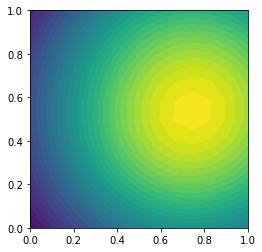

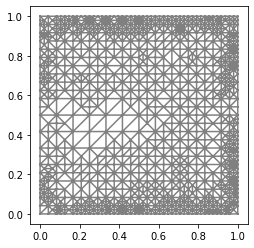

Done.

Solving on slab_2 = Ω x (0.03125, 0.04688) ...
eq.lhs =  { v_0[0] * f_1847[0] * f_1850 } * dx(<Mesh #1833>[everywhere], {})
  +  { f_1852 * v_0[0] * f_1847[0] } * dx(<Mesh #1833>[everywhere], {})
  +  { f_1853 * (conj(((grad(v_0[0])) : (grad(f_1847[0]))))) } * dx(<Mesh #1833>[everywhere], {})
  +  { f_1854 * v_0[0] * f_1847[0] } * dx(<Mesh #1833>[everywhere], {})
  +  { f_1855 * (conj(((grad(v_0[0])) : (grad(f_1847[0]))))) } * dx(<Mesh #1833>[everywhere], {})
  +  { f_1856 * v_0[0] * f_1847[1] } * dx(<Mesh #1833>[everywhere], {})
  +  { f_1857 * (conj(((grad(v_0[0])) : (grad(f_1847[1]))))) } * dx(<Mesh #1833>[everywhere], {})
  +  { f_1858 * v_0[0] * f_1847[1] } * dx(<Mesh #1833>[everywhere], {})
  +  { f_1859 * (conj(((grad(v_0[0])) : (grad(f_1847[1]))))) } * dx(<Mesh #1833>[everywhere], {})
  +  { f_1860 * f_1847[0] * v_0[1] } * dx(<Mesh #1833>[everywhere], {})
  +  { f_1861 * ((grad(f_1847[0])) : (grad(v_0[1]))) } * dx(<Mesh #1833>[everywhere], {})
  +  { f_1862 * f_1847[0] *

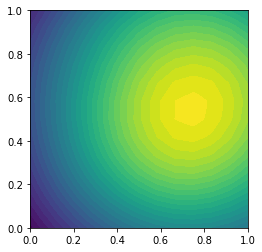

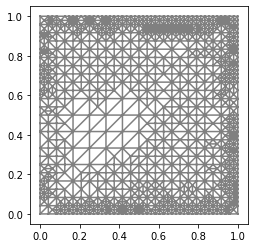

Done.

Solving on slab_3 = Ω x (0.04688, 0.0625) ...
eq.lhs =  { v_0[0] * f_2842[0] * f_2845 } * dx(<Mesh #2828>[everywhere], {})
  +  { f_2847 * v_0[0] * f_2842[0] } * dx(<Mesh #2828>[everywhere], {})
  +  { f_2848 * (conj(((grad(v_0[0])) : (grad(f_2842[0]))))) } * dx(<Mesh #2828>[everywhere], {})
  +  { f_2849 * v_0[0] * f_2842[0] } * dx(<Mesh #2828>[everywhere], {})
  +  { f_2850 * (conj(((grad(v_0[0])) : (grad(f_2842[0]))))) } * dx(<Mesh #2828>[everywhere], {})
  +  { f_2851 * v_0[0] * f_2842[1] } * dx(<Mesh #2828>[everywhere], {})
  +  { f_2852 * (conj(((grad(v_0[0])) : (grad(f_2842[1]))))) } * dx(<Mesh #2828>[everywhere], {})
  +  { f_2853 * v_0[0] * f_2842[1] } * dx(<Mesh #2828>[everywhere], {})
  +  { f_2854 * (conj(((grad(v_0[0])) : (grad(f_2842[1]))))) } * dx(<Mesh #2828>[everywhere], {})
  +  { f_2855 * f_2842[0] * v_0[1] } * dx(<Mesh #2828>[everywhere], {})
  +  { f_2856 * ((grad(f_2842[0])) : (grad(v_0[1]))) } * dx(<Mesh #2828>[everywhere], {})
  +  { f_2857 * f_2842[0] * 

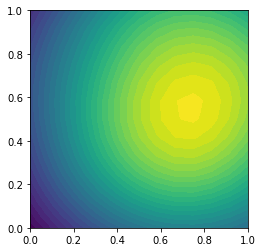

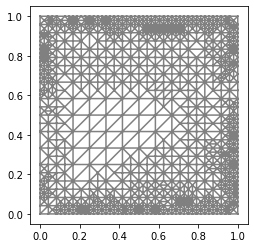

Done.

Solving on slab_4 = Ω x (0.0625, 0.07812) ...
eq.lhs =  { v_0[0] * f_3837[0] * f_3840 } * dx(<Mesh #3823>[everywhere], {})
  +  { f_3842 * v_0[0] * f_3837[0] } * dx(<Mesh #3823>[everywhere], {})
  +  { f_3843 * (conj(((grad(v_0[0])) : (grad(f_3837[0]))))) } * dx(<Mesh #3823>[everywhere], {})
  +  { f_3844 * v_0[0] * f_3837[0] } * dx(<Mesh #3823>[everywhere], {})
  +  { f_3845 * (conj(((grad(v_0[0])) : (grad(f_3837[0]))))) } * dx(<Mesh #3823>[everywhere], {})
  +  { f_3846 * v_0[0] * f_3837[1] } * dx(<Mesh #3823>[everywhere], {})
  +  { f_3847 * (conj(((grad(v_0[0])) : (grad(f_3837[1]))))) } * dx(<Mesh #3823>[everywhere], {})
  +  { f_3848 * v_0[0] * f_3837[1] } * dx(<Mesh #3823>[everywhere], {})
  +  { f_3849 * (conj(((grad(v_0[0])) : (grad(f_3837[1]))))) } * dx(<Mesh #3823>[everywhere], {})
  +  { f_3850 * f_3837[0] * v_0[1] } * dx(<Mesh #3823>[everywhere], {})
  +  { f_3851 * ((grad(f_3837[0])) : (grad(v_0[1]))) } * dx(<Mesh #3823>[everywhere], {})
  +  { f_3852 * f_3837[0] * 

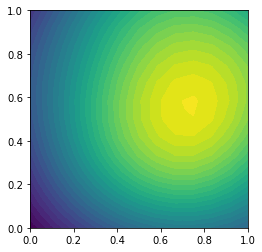

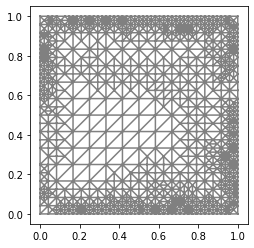

Done.

Solving on slab_5 = Ω x (0.07812, 0.09375) ...
eq.lhs =  { v_0[0] * f_4832[0] * f_4835 } * dx(<Mesh #4818>[everywhere], {})
  +  { f_4837 * v_0[0] * f_4832[0] } * dx(<Mesh #4818>[everywhere], {})
  +  { f_4838 * (conj(((grad(v_0[0])) : (grad(f_4832[0]))))) } * dx(<Mesh #4818>[everywhere], {})
  +  { f_4839 * v_0[0] * f_4832[0] } * dx(<Mesh #4818>[everywhere], {})
  +  { f_4840 * (conj(((grad(v_0[0])) : (grad(f_4832[0]))))) } * dx(<Mesh #4818>[everywhere], {})
  +  { f_4841 * v_0[0] * f_4832[1] } * dx(<Mesh #4818>[everywhere], {})
  +  { f_4842 * (conj(((grad(v_0[0])) : (grad(f_4832[1]))))) } * dx(<Mesh #4818>[everywhere], {})
  +  { f_4843 * v_0[0] * f_4832[1] } * dx(<Mesh #4818>[everywhere], {})
  +  { f_4844 * (conj(((grad(v_0[0])) : (grad(f_4832[1]))))) } * dx(<Mesh #4818>[everywhere], {})
  +  { f_4845 * f_4832[0] * v_0[1] } * dx(<Mesh #4818>[everywhere], {})
  +  { f_4846 * ((grad(f_4832[0])) : (grad(v_0[1]))) } * dx(<Mesh #4818>[everywhere], {})
  +  { f_4847 * f_4832[0] *

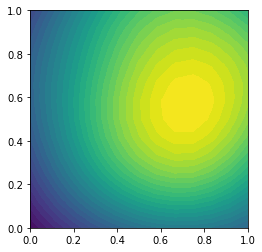

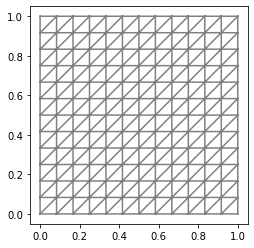

Done.

Solving on slab_6 = Ω x (0.09375, 0.10938) ...
eq.lhs =  { v_0[0] * f_5356[0] * f_5359 } * dx(<Mesh #5342>[everywhere], {})
  +  { f_5361 * v_0[0] * f_5356[0] } * dx(<Mesh #5342>[everywhere], {})
  +  { f_5362 * (conj(((grad(v_0[0])) : (grad(f_5356[0]))))) } * dx(<Mesh #5342>[everywhere], {})
  +  { f_5363 * v_0[0] * f_5356[0] } * dx(<Mesh #5342>[everywhere], {})
  +  { f_5364 * (conj(((grad(v_0[0])) : (grad(f_5356[0]))))) } * dx(<Mesh #5342>[everywhere], {})
  +  { f_5365 * v_0[0] * f_5356[1] } * dx(<Mesh #5342>[everywhere], {})
  +  { f_5366 * (conj(((grad(v_0[0])) : (grad(f_5356[1]))))) } * dx(<Mesh #5342>[everywhere], {})
  +  { f_5367 * v_0[0] * f_5356[1] } * dx(<Mesh #5342>[everywhere], {})
  +  { f_5368 * (conj(((grad(v_0[0])) : (grad(f_5356[1]))))) } * dx(<Mesh #5342>[everywhere], {})
  +  { f_5369 * f_5356[0] * v_0[1] } * dx(<Mesh #5342>[everywhere], {})
  +  { f_5370 * ((grad(f_5356[0])) : (grad(v_0[1]))) } * dx(<Mesh #5342>[everywhere], {})
  +  { f_5371 * f_5356[0] *

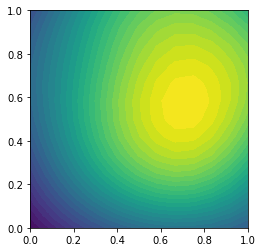

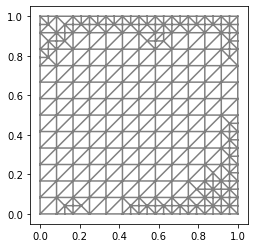

Done.

Solving on slab_7 = Ω x (0.10938, 0.125) ...
eq.lhs =  { v_0[0] * f_6037[0] * f_6040 } * dx(<Mesh #6023>[everywhere], {})
  +  { f_6042 * v_0[0] * f_6037[0] } * dx(<Mesh #6023>[everywhere], {})
  +  { f_6043 * (conj(((grad(v_0[0])) : (grad(f_6037[0]))))) } * dx(<Mesh #6023>[everywhere], {})
  +  { f_6044 * v_0[0] * f_6037[0] } * dx(<Mesh #6023>[everywhere], {})
  +  { f_6045 * (conj(((grad(v_0[0])) : (grad(f_6037[0]))))) } * dx(<Mesh #6023>[everywhere], {})
  +  { f_6046 * v_0[0] * f_6037[1] } * dx(<Mesh #6023>[everywhere], {})
  +  { f_6047 * (conj(((grad(v_0[0])) : (grad(f_6037[1]))))) } * dx(<Mesh #6023>[everywhere], {})
  +  { f_6048 * v_0[0] * f_6037[1] } * dx(<Mesh #6023>[everywhere], {})
  +  { f_6049 * (conj(((grad(v_0[0])) : (grad(f_6037[1]))))) } * dx(<Mesh #6023>[everywhere], {})
  +  { f_6050 * f_6037[0] * v_0[1] } * dx(<Mesh #6023>[everywhere], {})
  +  { f_6051 * ((grad(f_6037[0])) : (grad(v_0[1]))) } * dx(<Mesh #6023>[everywhere], {})
  +  { f_6052 * f_6037[0] * v

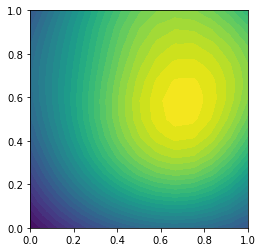

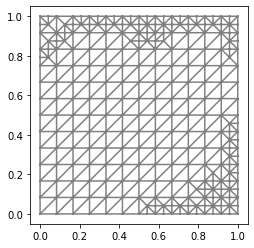

Done.

Solving on slab_8 = Ω x (0.125, 0.14062) ...
eq.lhs =  { v_0[0] * f_6718[0] * f_6721 } * dx(<Mesh #6704>[everywhere], {})
  +  { f_6723 * v_0[0] * f_6718[0] } * dx(<Mesh #6704>[everywhere], {})
  +  { f_6724 * (conj(((grad(v_0[0])) : (grad(f_6718[0]))))) } * dx(<Mesh #6704>[everywhere], {})
  +  { f_6725 * v_0[0] * f_6718[0] } * dx(<Mesh #6704>[everywhere], {})
  +  { f_6726 * (conj(((grad(v_0[0])) : (grad(f_6718[0]))))) } * dx(<Mesh #6704>[everywhere], {})
  +  { f_6727 * v_0[0] * f_6718[1] } * dx(<Mesh #6704>[everywhere], {})
  +  { f_6728 * (conj(((grad(v_0[0])) : (grad(f_6718[1]))))) } * dx(<Mesh #6704>[everywhere], {})
  +  { f_6729 * v_0[0] * f_6718[1] } * dx(<Mesh #6704>[everywhere], {})
  +  { f_6730 * (conj(((grad(v_0[0])) : (grad(f_6718[1]))))) } * dx(<Mesh #6704>[everywhere], {})
  +  { f_6731 * f_6718[0] * v_0[1] } * dx(<Mesh #6704>[everywhere], {})
  +  { f_6732 * ((grad(f_6718[0])) : (grad(v_0[1]))) } * dx(<Mesh #6704>[everywhere], {})
  +  { f_6733 * f_6718[0] * v

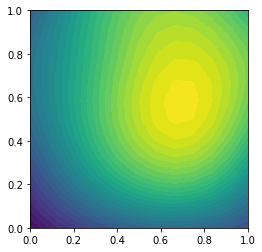

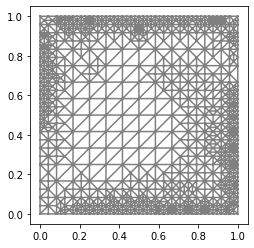

Done.

Solving on slab_9 = Ω x (0.14062, 0.15625) ...
eq.lhs =  { v_0[0] * f_7713[0] * f_7716 } * dx(<Mesh #7699>[everywhere], {})
  +  { f_7718 * v_0[0] * f_7713[0] } * dx(<Mesh #7699>[everywhere], {})
  +  { f_7719 * (conj(((grad(v_0[0])) : (grad(f_7713[0]))))) } * dx(<Mesh #7699>[everywhere], {})
  +  { f_7720 * v_0[0] * f_7713[0] } * dx(<Mesh #7699>[everywhere], {})
  +  { f_7721 * (conj(((grad(v_0[0])) : (grad(f_7713[0]))))) } * dx(<Mesh #7699>[everywhere], {})
  +  { f_7722 * v_0[0] * f_7713[1] } * dx(<Mesh #7699>[everywhere], {})
  +  { f_7723 * (conj(((grad(v_0[0])) : (grad(f_7713[1]))))) } * dx(<Mesh #7699>[everywhere], {})
  +  { f_7724 * v_0[0] * f_7713[1] } * dx(<Mesh #7699>[everywhere], {})
  +  { f_7725 * (conj(((grad(v_0[0])) : (grad(f_7713[1]))))) } * dx(<Mesh #7699>[everywhere], {})
  +  { f_7726 * f_7713[0] * v_0[1] } * dx(<Mesh #7699>[everywhere], {})
  +  { f_7727 * ((grad(f_7713[0])) : (grad(v_0[1]))) } * dx(<Mesh #7699>[everywhere], {})
  +  { f_7728 * f_7713[0] *

KeyboardInterrupt: 

In [3]:
##############################################
# Start a time marching / time slabbing loop #
##############################################
start_time = 0.
end_time = 1.

conv_table_start_time = time.time()
convergence_table = {}
for s in [1]: #[1, 2]: # polynomial degree in space
    for r in [1]: #[0, 1, 2]: # polynomial degree in time
        convergence_table[r, s] = {}
        slab_size = 1. * 0.125 * 0.25
        n_x = 6
        for i in range(1): #7): #8):
            slab_size *= 0.5
            n_x *= 2
            
            # start simulation
            cpu_start_time = time.time()
            print(f"CONFIG: s = {s}, r = {r}, slab_size = {slab_size}, n_x = {n_x}")

            slabs = [(start_time, start_time+slab_size)]
            while slabs[-1][1] < end_time - 1e-8:
                slabs.append((slabs[-1][1], slabs[-1][1]+slab_size))

            L2_error = 0.
            total_n_dofs = 0
            total_time_n_dofs = 0
            last_solution = None

            #####################
            # Time slabbing loop:
            for k, slab in enumerate(slabs):
                print(f"Solving on slab_{k} = Ω x ({round(slab[0],5)}, {round(slab[1],5)}) ...")

                # get spatial function space
                space_mesh = UnitSquareMesh(n_x, n_x) # \Omega = (0,1)x(0,1)
                #plot(space_mesh, title="spatial mesh")
                #plt.show()
                Vh = FunctionSpace(space_mesh, 'CG', s) # spatial function space for a single time point
                uh = Function(Vh)
                phih = TestFunction(Vh)

                # analytical solution
                u_analytical = Expression('1.0/(pow(x[0] - 0.25*cos(2*pi*t) - 0.5, 2) + pow(x[1] - 0.25*sin(2*pi*t) - 0.5, 2) + 1)', degree=4, pi=np.pi, t=0.)

                # initial condition on slab
                if last_solution is None: 
                    u0 = interpolate(u_analytical, Vh)
                else:
                    u0 = interpolate(u0, Vh)
                    
                # preassemble spatial forms
                mass_form = uh*phih*dx
                laplace_form = inner(grad(uh), grad(phih))*dx
                
                #########################################
                # Create temporal finite element object #
                #########################################
                Time = TimeFE(r=r, a=slab[0], b=slab[1], n_time=2, n_q_points=r+1)

                element_u = FiniteElement("CG", space_mesh.ufl_cell(), s)
                V = FunctionSpace(space_mesh, MixedElement(*[element_u for _ in range(Time.n_dofs)]))

                U = Function(V)
                Phi = TestFunctions(V)

                # start with "empty" space-time variational form
                F = Constant(0.)*U[0]*Phi[0]*dx
                rhs_force = Expression('(4*pow(-x[0] + 0.25*cos(2*pi*t) + 0.5, 2) - 8.0*pow(1.0*x[0] - 0.25*cos(2*pi*t) - 0.5, 2) + 4*pow(-x[1] + 0.25*sin(2*pi*t) + 0.5, 2) - 8.0*pow(1.0*x[1] - 0.25*sin(2*pi*t) - 0.5, 2) + 1.0*pi*(-1.0*x[0]*sin(2*pi*t) + 1.0*x[1]*cos(2*pi*t) - 0.5*M_SQRT2*cos(pi*(2*t + 1.0/4.0)))*(pow(-x[0] + 0.25*cos(2*pi*t) + 0.5, 2) + pow(-x[1] + 0.25*sin(2*pi*t) + 0.5, 2) + 1) + 4)/pow(pow(-x[0] + 0.25*cos(2*pi*t) + 0.5, 2) + pow(-x[1] + 0.25*sin(2*pi*t) + 0.5, 2) + 1, 3)', degree=4, pi=np.pi, t=0.)
                
                # volume integrals
                for time_element in Time.mesh:
                    for i in Time.local_dofs[time_element]:
                        for j in Time.local_dofs[time_element]:
                            for (t_q, w_q) in Time.quadrature[time_element]:
                                F += Constant(w_q * Time.dt_phi[j](t_q) * Time.phi[i](t_q)) * replace(mass_form, {uh: U[j], phih: Phi[i]})
                                F += Constant(w_q * Time.phi[j](t_q) * Time.phi[i](t_q)) * replace(laplace_form, {uh: U[j], phih: Phi[i]})
                             
                # RHS integral
                for n, time_element in enumerate(Time.mesh):
                    for i in Time.local_dofs[time_element]:
                        # initial condition
                        if n == 0:
                            F -=  Constant(Time.phi[i](time_element[0]+Time.epsilon)) * u0 * Phi[i] * dx

                        for (t_q, w_q) in Time.quadrature_fine[time_element]:
                            # forcing function
                            #rhs_force.t = t_q
                            #F -= Constant(w_q * Time.phi[i](t_q)) * rhs_force * Phi[i] * dx 
                            # for debugging:
                            F -= Constant(w_q * Time.phi[i](t_q)) * Expression('(4*pow(-x[0] + 0.25*cos(2*pi*t) + 0.5, 2) - 8.0*pow(1.0*x[0] - 0.25*cos(2*pi*t) - 0.5, 2) + 4*pow(-x[1] + 0.25*sin(2*pi*t) + 0.5, 2) - 8.0*pow(1.0*x[1] - 0.25*sin(2*pi*t) - 0.5, 2) + 1.0*pi*(-1.0*x[0]*sin(2*pi*t) + 1.0*x[1]*cos(2*pi*t) - 0.5*M_SQRT2*cos(pi*(2*t + 1.0/4.0)))*(pow(-x[0] + 0.25*cos(2*pi*t) + 0.5, 2) + pow(-x[1] + 0.25*sin(2*pi*t) + 0.5, 2) + 1) + 4)/pow(pow(-x[0] + 0.25*cos(2*pi*t) + 0.5, 2) + pow(-x[1] + 0.25*sin(2*pi*t) + 0.5, 2) + 1, 3)', degree=4, pi=np.pi, t=t_q) * Phi[i] * dx 


                # jump terms (NOTE: For Gauss-Lobatto dG basis, we can hard code the values for the jump term)
                for n, time_element in enumerate(Time.mesh):
                    # a) u_m^+ * φ_m^+
                    for i in Time.local_dofs[time_element]:
                        for j in Time.local_dofs[time_element]:
                            F += Constant(Time.phi[j](time_element[0]+Time.epsilon) * Time.phi[i](time_element[0]+Time.epsilon)) * replace(mass_form, {uh: U[j], phih: Phi[i]})
                            
                    # b) u_{m-1}^- * φ_m^+
                    if n > 0:
                        prev_time_element = Time.mesh[n-1]
                        for i in Time.local_dofs[time_element]:
                            for j in Time.local_dofs[prev_time_element]:
                                F += Constant((-1.) * Time.phi[j](prev_time_element[1]-Time.epsilon) * Time.phi[i](time_element[0]+Time.epsilon)) * replace(mass_form, {uh: U[j], phih: Phi[i]})       
                                
                # define time dependent Dirichlet boundary conditions
                bcs = []
                for i, t_q in enumerate(Time.dof_locations):
                    u_analytical.t = t_q
                    if Time.n_dofs > 1:
                        bcs.append(DirichletBC(V.sub(i), u_analytical, lambda _, on_boundary: on_boundary))
                    else:
                        # for dG(0) with 1 temporal element Vh = V
                        raise NotImplementedError("Make sure that Time.n_dofs > 1, because otherwise V.sub(i) doesn't work")

                dU = TrialFunction(V)
                
                # Gateaux derivative of F w.r.t. to U in direction of dU
                J = derivative(F, U, dU) 
                        
                # solve problem
                M = Constant(0.)*U[0]*dx
                """
                for time_element in Time.mesh:
                    for i in Time.local_dofs[time_element]:
                        for (t_q, w_q) in Time.quadrature_fine[time_element]:
                            M += Constant(w_q * Time.phi[i](t_q)) * U[i] * dx
                """
                
                """
                for time_element in Time.mesh:
                    for i in Time.local_dofs[time_element]:
                        for j in Time.local_dofs[time_element]:
                            for (t_q, w_q) in Time.quadrature_fine[time_element]:
                                M += Constant(w_q * Time.phi[j](t_q) * Time.phi[i](t_q)) * U[i] * U[j] * dx
                """
                for time_element in Time.mesh:
                    for (t_q, w_q) in Time.quadrature_fine[time_element]:
                        u_q_analytical = Expression('1.0/(pow(x[0] - 0.25*cos(2*pi*t) - 0.5, 2) + pow(x[1] - 0.25*sin(2*pi*t) - 0.5, 2) + 1)', degree=4, pi=np.pi, t=t_q)
                        
                        # (a-b)^2 = a^2 - ...
                        #M += Constant(w_q) * u_q_analytical**2 * dx
                        
                        # (a-b)^2 = ... - 2ab + ...
                        for i in Time.local_dofs[time_element]:
                            M += Constant(-1. * w_q * Time.phi[i](t_q)) * U[i] * u_q_analytical * dx
                        
                        # (a-b)^2 = ... + b^2
                        for i in Time.local_dofs[time_element]:
                            for J in Time.local_dofs[time_element]:
                                M += Constant(w_q * Time.phi[i](t_q) * Time.phi[j](t_q)) * U[i] * U[j] * dx
                        
                solve(F == 0, U, bcs, tol=5e-8, M=M) #U[0]*dx) # TODO: adapt to adaptive mesh refinement
                
                # get u0 for next slab
                u0 = Time.get_solution_at_time(slab[1]-Time.epsilon, Vh) #Vh_new)
                plot(u0)
                plt.show()
                
                #plt.rcParams["figure.figsize"] = [15,15]
                plot(U.leaf_node().ufl_function_space().mesh())
                plt.show()

                # prepare convergence plot
                total_time_n_dofs += Time.n_dofs
                total_n_dofs += Vh.dim() * Time.n_dofs 
                for time_element in Time.mesh:
                    for (t_q, w_q) in Time.quadrature_fine[time_element]:
                        u_q_FEM = Time.get_solution_at_time(t_q, Vh)
                        u_analytical.t = t_q
                        u_q_analytical = interpolate(u_analytical, Vh)
                        L2_error += w_q * assemble((u_q_analytical-u_q_FEM)**2*dx)
                print("Done.\n")

            print("------------")
            print("| RESULTS: |")
            print("------------")
            print(f"Space-time Dofs: {total_n_dofs}")
            print("L2 error:", L2_error)
            cpu_time = round(time.time() - cpu_start_time, 5)
            print(f"CPU Time: {cpu_time} s \n\n")
            convergence_table[r, s][Vh.dim(), total_time_n_dofs] = {"dofs": total_n_dofs, "error": f"{L2_error:.3e}", "time": cpu_time}
                         
print(f"\n\nTime for creating convergence table: {round(time.time() - conv_table_start_time, 5)} s")
print("Convergence table:")
for (r, s) in convergence_table.keys():
    print(f"r = {r}, s = {s}:", convergence_table[r, s])
    X = []
    Y = []
    for val in convergence_table[r, s].values():
        X.append(val["dofs"])
        Y.append(float(val["error"]))
    plt.plot(X, Y, label=f"r={r},s={s}")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
# TODO: use this later for adaptive mesh refinement
plt.rcParams["figure.figsize"] = [15,15]
plot(U.leaf_node().ufl_function_space().mesh())
plt.show()

In [ ]:
from sympy import *

x, y , t = symbols("x y t")
init_printing()

x0 = 1/2 + (1/4)*cos(2*pi*t)
y0 = 1/2 + (1/4)*sin(2*pi*t)
u = 1 / (1 + (x-x0)**2 + (y-y0)**2)
u

In [ ]:
rhs_func = simplify(diff(u, t) - diff(u, x, 2) - diff(u, y, 2))
rhs_func

In [ ]:
ccode(rhs_func).replace("x","x[0]").replace("y","x[1]").replace("M_PI", "pi")

In [ ]:
ccode(u).replace("x","x[0]").replace("y","x[1]").replace("M_PI", "pi")